# Detection of stages: Light, Deep, REM, Wake Movement

Database source: 
    
    Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals. Circulation 101(23):e215-e220 [Circulation Electronic Pages; http://circ.ahajournals.org/content/101/23/e215.full]; 2000 (June 13).


In [1]:
from __future__ import division
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as ss
import seaborn as sns
from scipy.ndimage import convolve1d
import itertools
import sleep_utils as su

# import psycopg2
import datetime  
import time 
import wfdb
import glob

from biosppy.signals import ecg

%matplotlib inline
sns.set()
pd.set_option("display.max_columns", None)
%load_ext autoreload
%autoreload 2

## Load a file from database

In [2]:
data_dir = '../data/PSG_database/'

co2_sig = []
ppg_sig = []

filenames = []

sleep_data_sigs = {}
sleep_data_fields = {}

data_keys = []
for fname in glob.iglob(data_dir + '/*.dat'):#, recursive=True):
    # filename manipulation
    base = os.path.basename(fname)
    key = os.path.splitext(base)[0]
    data_keys.append(key)
    
    # load data
    sig, fields=wfdb.rdsamp(data_dir+key)
    sleep_data_sigs[key] = sig
    sleep_data_fields[key] = fields

In [3]:
ann_index = {}
ann_labels = {}

set_stages = set()
for key in data_keys:
    annotation = wfdb.rdann(data_dir + key, 'st')
    ann_index_sig = annotation[0]
    ann_label_sig = annotation[5]
    label_filt = [(x, y) for x, y in zip(ann_index_sig, ann_label_sig) if x >1 ]
    unzipped = zip(*label_filt)
    ann_index[key] = unzipped[0]
    ann_labels[key] = unzipped[1]


In [4]:
resp_data_set = {}
ecg_data_set = {}
bp_data_set = {}
time_data_set = {}
annot_data_set = {}


fs = 250
dec_prec = len(str(1/fs).split('.')[1])

for key in data_keys:
    
    resp_data_set[key] = (sleep_data_sigs[key])[:, (sleep_data_fields[key])['signame'].index('Resp')]
    ecg_data_set[key] = (sleep_data_sigs[key])[:, (sleep_data_fields[key])['signame'].index('ECG')]
    bp_data_set[key] = (sleep_data_sigs[key])[:, (sleep_data_fields[key])['signame'].index('BP')]
    time_data_set[key] = np.arange(0, len(resp_data_set[key]))/fs

    # Note: Only the first character of the annotation was taken as label
    # Example: 1, 2, 3, 4, R, W, M
    stages_list = [x.rsplit(' ')[0][0] for x in ann_labels[key]]

    annot_data_set[key] = stages_list


#### *Annotations*

Stages:
   * W: subject is awake
   * 1: sleep stage 1
   * 2: sleep stage 2
   * 3: sleep stage 3
   * 4: sleep stage 4
   * R: REM sleep
   
Other descriptions:
   * H: Hypopnea
   * HA: Hypopnea with arousal
   * OA: Obstructive apnea
   * X: Obstructive apnea with arousal
   * CA: Central apnea
   * CAA: Central apnea with arousal
   * L: Leg movements
   * LA: Leg movements with arousal
   * A: Unspecified arousal
   * MT: Movement time

## Get Features

### I. Previous sleep stage

Note: Get features for every window of data

In [5]:
win_dur = 30 # duration of window, unit: seconds, size of one epoch 
win_size = fs*win_dur # length of window
win_step = 1 # duration by which the window slides, unit: seconds
win_int = win_step*fs # length by which the window slides

In [6]:
feature_prev_stage = {}
feature_prev_stage_light = {}
feature_prev_stage_deep = {}
feature_prev_stage_rem = {}
feature_prev_stage_wake = {}
feature_prev_stage_move = {}

for key in data_keys:
    previous = annot_data_set[key][1:]
    prev_stage = [np.nan] + previous
    feature_prev_stage[key] = {'_feat' : prev_stage}
    
    # NREM-light or not
    feature_prev_stage_light[key] = {'_feat' : [np.nan] +map(lambda x: 0 if x not in ['1', '2'] else 1, previous)}
    
    # NREM-deep or not
    feature_prev_stage_deep[key] = {'_feat' : [np.nan] +map(lambda x: 0 if x not in ['1', '2'] else 1, previous)}
    
    # REM or not
    feature_prev_stage_rem[key] = {'_feat' : [np.nan] + map(lambda x: 0 if x!= 'R' else 1,previous)}
    
    # Wake or not
    feature_prev_stage_wake[key] = {'_feat' :[np.nan] + map(lambda x: 0 if x!= 'W' else 1,previous)}
    
    # Wake or not
    feature_prev_stage_move[key] = {'_feat' :[np.nan] + map(lambda x: 0 if x!= 'M' else 1,previous)}


### II. Respiration signal

In [7]:
# Respiratory frequency range 
min_normrange = 4/60 # unit: cycles per second
max_normrange = 65/60 # unit: cycles per second

resp_data_set_epochs = {}

# Divide ECG data per 30-second epoch. 

for key in data_keys:
    resp_sig = resp_data_set[key]
    fft_resp = np.fft.fft(resp_sig)
    fft_freqs = np.fft.fftfreq(len(resp_sig), 1/fs)
    
    # Remove frequencies which are outside the expected range
    fft_resp[abs(fft_freqs) < min_normrange] = 0
    fft_resp[abs(fft_freqs) > max_normrange] = 0
    
    resp_filt_sig = np.real(np.fft.ifft(fft_resp))
    time_sig = np.arange(len(resp_sig))/fs

    # Divide into windows
    resp_windows = su.divide_to_epochs(resp_filt_sig, ann_index[key], win_dur, fs)
    time_windows = su.divide_to_epochs(time_sig, ann_index[key], win_dur, fs)
    
    resp_data_set_epochs[key] = pd.DataFrame({'resp': list(resp_windows), '_time': list(time_windows)})


#### II.1 Respiration rate
*Frequency corresponding to the highest peak in the epoch's power spectrum (unit: breaths/minute)*

In [8]:
feature_resp_rate = {}
# feature_resp_rate_fd = {}
# feature_resp_rate_sd = {}

for key in data_keys:
    resp_data = resp_data_set_epochs[key]
    resp_data['power_spectrum'] = resp_data.resp.apply(lambda x: ss.periodogram(x, fs=fs))
    
    # Compute respiration rate
    resp_data['resp_rate'] = resp_data.power_spectrum.apply(lambda x: (x[0])[np.argmax(x[1])]*60)

    feature_resp_rate[key] = {'_feat' : resp_data.resp_rate.values}


#### II.2 Histogram of Respiration data
Use the counts for each bin of the magnitude histogram.

In [9]:
nbins = 5

feature_hist_resp = {}

for key in data_keys:
#     print("Computing for "+ key + "...")
    resp_data = resp_data_set_epochs[key]

    hist_windows = resp_data.resp.apply(lambda x: np.histogram(x, bins=nbins, normed=True)[0])
    feature_hist_resp[key] = {'_feat' : (np.asarray(hist_windows))}

#### II.3 Ratio of standard deviation and mean of magnitude

In [10]:
feature_mean_vs_std_resp = {}

for key in data_keys:
#     print("Computing for "+ key + "...")
    resp_data = resp_data_set_epochs[key]

    mean_vs_std = resp_data.resp.apply(lambda x: (np.mean(x)/np.std(x)))
    feature_mean_vs_std_resp[key] = {'_feat' : list(mean_vs_std)}

#### II.4 Ratio of  mean and standard deviation  of peak-to-peak duration of respiration signal

In [11]:
feature_mean_vs_std_p2p_dur_resp = {}
# feature_max_vs_std_p2p_dur_resp = {}
# feature_min_vs_std_p2p_dur_resp = {}

for key in data_keys:
    print("Computing for "+ key + "...")
    resp_data = resp_data_set_epochs[key]

    p2p_dur = resp_data.resp.apply(lambda x: su.bio_signal_peak_detect(x, fs, 'resp'))\
                            .apply(lambda x: np.array(x[0][1:]) - np.array(x[0][:-1]))
    mean_vs_std = p2p_dur.apply(lambda x: np.nanmean(x)/np.nanstd(x))
    feature_mean_vs_std_p2p_dur_resp[key] = {'_feat' : list(mean_vs_std)}           
    
#### II.5 Ratio of max and mean of magnitude of peak-to-peak duration
#### II.6 Ratio of min and mean of magnitude of peak-to-peak duration
    
#     max_vs_std = p2p_dur.apply(lambda x: np.nanmax(x)/np.nanmean(x))
#     feature_max_vs_mean_p2p_dur_resp[key] = {'_feat' : list(max_vs_std)}           
    
#     min_vs_std = p2p_dur.apply(lambda x: np.nanmin(x)/np.nanmean(x))
#     feature_min_vs_mean_p2p_dur_resp[key] = {'_feat' : list(min_vs_std)}           


Computing for slp01a...


peakdetect.py:200: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  for index, (x, y) in enumerate(zip(x_axis[:-lookahead],
peakdetect.py:201: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y_axis[:-lookahead])):
peakdetect.py:213: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if y_axis[index:index+lookahead].max() < mx:
peakdetect.py:231: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if y_axis[index:index+lookahead].min() > mn:


Computing for slp01b...
Computing for slp02a...
Computing for slp02b...
Computing for slp03...
Computing for slp04...
Computing for slp14...
Computing for slp16...
Computing for slp32...


/Users/eventura/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/eventura/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1147: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


Computing for slp37...
Computing for slp41...
Computing for slp45...
Computing for slp48...
Computing for slp59...
Computing for slp60...
Computing for slp61...
Computing for slp66...
Computing for slp67x...


#### II.5 Ratio of mean and standard deviation of amplitude
#### II.5 Ratio of max and mean of magnitude of amplitude
#### II.6 Ratio of min and mean of magnitude of amplitude
 

In [12]:
feature_mean_vs_std_amp_resp = {}
feature_max_vs_mean_amp_resp = {}
feature_min_vs_mean_amp_resp = {}

for key in data_keys:
    print("Computing for "+ key + "...")
    resp_data = resp_data_set_epochs[key]

    amplitude = resp_data.resp.apply(lambda x: su.compute_amplitude(x, fs, 'resp'))
    mean_vs_std = amplitude.apply(lambda x: np.nanmean(x)/np.nanstd(x))
    feature_mean_vs_std_amp_resp[key] = {'_feat' : list(mean_vs_std)}           
    
    max_vs_mean = amplitude.apply(lambda x: np.nanmax(x)/np.nanmean(x))
    feature_max_vs_mean_amp_resp[key] = {'_feat' : list(max_vs_mean)}           
    
    min_vs_mean = amplitude.apply(lambda x: np.nanmax(x)/np.nanmean(x))
    feature_min_vs_mean_amp_resp[key] = {'_feat' : list(min_vs_mean)}    

Computing for slp01a...
Computing for slp01b...
Computing for slp02a...
Computing for slp02b...
Computing for slp03...
Computing for slp04...
Computing for slp14...
Computing for slp16...
Computing for slp32...


/Users/eventura/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:326: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


Computing for slp37...
Computing for slp41...
Computing for slp45...
Computing for slp48...
Computing for slp59...
Computing for slp60...
Computing for slp61...
Computing for slp66...
Computing for slp67x...


### III. ECG signal

In [13]:
# Divide ECG data per 30-second epoch. 

ecg_data_set_epochs = {}

for key in data_keys:
    ecg_sig = ecg_data_set[key]
    time_sig = np.arange(len(ecg_sig))/fs

    # Divide into windows
    ecg_windows = su.divide_to_epochs(ecg_sig, ann_index[key], win_dur, fs)
    time_windows = su.divide_to_epochs(time_sig, ann_index[key], win_dur, fs)
    
    ecg_data_set_epochs[key] = pd.DataFrame({'ecg': list(ecg_windows), '_time': list(time_windows)})

#### III.1 Heart rate
*Reciprocal of the mean R-R interval in an epoch (unit: beats/minute)*


#### III.2 Heart rate variability
*Standard deviation of the R-R intervals in an epoch (unit: milliseconds)*


In [14]:
feature_heart_rate = {}
feature_heart_rate_var = {}

for key in data_keys:
    ecg_data = ecg_data_set_epochs[key]
    
    # Get time corresponding to R peaks
    ecg_data['r_peaks'] = ecg_data.ecg.apply(lambda x: ecg.hamilton_segmenter(x, sampling_rate=250)['rpeaks'])
    ecg_data['r_time'] = ecg_data.apply(lambda x: list(x._time[x.r_peaks]), axis = 1)
    
    # Compute heart rate
    ecg_data['heart_rate'] = ecg_data.r_time.apply(lambda x: su.heart_rate(np.array(x))*60)
    ecg_data['window_time'] = ecg_data['_time'].apply(lambda x: x[-1])
        
    # Compute heart rate variability
    ecg_data['heart_rate_var'] = ecg_data.r_time.apply(lambda x: su.heart_rate_var(np.array(x))*1000)
    
    feature_heart_rate[key] = {'_feat' : ecg_data.heart_rate.values}
    feature_heart_rate_var[key] = {'_feat' : ecg_data.heart_rate_var.values}

#### III.3 Histogram of ECG data
Use the counts for each bin of the magnitude histogram.

In [15]:
feature_hist_ecg = {}

for key in data_keys:
#     print("Computing for "+ key + "...")
    ecg_data = ecg_data_set_epochs[key]

    hist_windows = ecg_data.ecg.apply(lambda x: np.histogram(x, bins=nbins, normed=True)[0])
    feature_hist_ecg[key] = {'_feat' : (np.asarray(hist_windows))}

#### III.4 Ratio of standard deviation and mean of magnitude

In [16]:
feature_mean_vs_std_ecg = {}

for key in data_keys:
#     print("Computing for "+ key + "...")
    ecg_data = ecg_data_set_epochs[key]

    mean_vs_std = ecg_data.ecg.apply(lambda x: (np.mean(x)/np.std(x)))
    feature_mean_vs_std_ecg[key] = {'_feat' : list(mean_vs_std)}

#### III.5 Ratio of  mean and standard deviation  of peak-to-peak duration of ecg signal

In [17]:
feature_mean_vs_std_p2p_dur_ecg = {}

for key in data_keys:
    print("Computing for "+ key + "...")
    ecg_data = ecg_data_set_epochs[key]

    p2p_dur = ecg_data.ecg.apply(lambda x: su.bio_signal_peak_detect(x, fs, 'ecg'))\
                            .apply(lambda x: np.array(x[0][1:]) - np.array(x[0][:-1]))
    mean_vs_std = p2p_dur.apply(lambda x: np.nanmean(x)/np.nanstd(x))
    feature_mean_vs_std_p2p_dur_ecg[key] = {'_feat' : list(mean_vs_std)}           
    


Computing for slp01a...
Computing for slp01b...
Computing for slp02a...
Computing for slp02b...
Computing for slp03...
Computing for slp04...
Computing for slp14...
Computing for slp16...
Computing for slp32...
Computing for slp37...
Computing for slp41...
Computing for slp45...
Computing for slp48...
Computing for slp59...
Computing for slp60...
Computing for slp61...
Computing for slp66...
Computing for slp67x...


#### III.6 Ratio of mean and standard deviation of amplitude
#### III.7 Ratio of max and mean of magnitude of amplitude
#### III.8 Ratio of min and mean of magnitude of amplitude
 

In [18]:
feature_mean_vs_std_amp_ecg = {}
feature_max_vs_mean_amp_ecg = {}
feature_min_vs_mean_amp_ecg = {}

for key in data_keys:
    print("Computing for "+ key + "...")
    ecg_data = ecg_data_set_epochs[key]

    amplitude = ecg_data.ecg.apply(lambda x: su.compute_amplitude(x, fs, 'ecg'))
    mean_vs_std = amplitude.apply(lambda x: np.nanmean(x)/np.nanstd(x))
    feature_mean_vs_std_amp_ecg[key] = {'_feat' : list(mean_vs_std)}           
    
    max_vs_mean = amplitude.apply(lambda x: np.nanmax(x)/np.nanmean(x))
    feature_max_vs_mean_amp_ecg[key] = {'_feat' : list(max_vs_mean)}           
    
    min_vs_mean = amplitude.apply(lambda x: np.nanmax(x)/np.nanmean(x))
    feature_min_vs_mean_amp_ecg[key] = {'_feat' : list(min_vs_mean)}    

Computing for slp01a...
Computing for slp01b...
Computing for slp02a...
Computing for slp02b...
Computing for slp03...
Computing for slp04...
Computing for slp14...
Computing for slp16...
Computing for slp32...
Computing for slp37...
Computing for slp41...
Computing for slp45...
Computing for slp48...
Computing for slp59...
Computing for slp60...
Computing for slp61...
Computing for slp66...
Computing for slp67x...


### IV. Blood Pressure signal

In [19]:
# Divide ECG data per 30-second epoch. 

bp_data_set_epochs = {}

for key in data_keys:
    bp_sig = bp_data_set[key]
    time_sig = np.arange(len(bp_sig))/fs

    # Divide into windows
    bp_windows = su.divide_to_epochs(bp_sig, ann_index[key], win_dur, fs)
    time_windows = su.divide_to_epochs(time_sig, ann_index[key], win_dur, fs)
    
    bp_data_set_epochs[key] = pd.DataFrame({'bp': list(bp_windows), '_time': list(time_windows)})


#### IV.1 Histogram of BP data
Use the counts for each bin of the magnitude histogram.

In [20]:
feature_hist_bp = {}

for key in data_keys:
#     print("Computing for "+ key + "...")
    bp_data = bp_data_set_epochs[key]

    hist_windows = bp_data.bp.apply(lambda x: np.histogram(x, bins=nbins, normed=True)[0])
    feature_hist_bp[key] = {'_feat' : (np.asarray(hist_windows))}

#### IV.2 Ratio of standard deviation and mean of magnitude

In [21]:
feature_mean_vs_std_bp = {}

for key in data_keys:
#     print("Computing for "+ key + "...")
    bp_data = bp_data_set_epochs[key]

    mean_vs_std = bp_data.bp.apply(lambda x: (np.mean(x)/np.std(x)))
    feature_mean_vs_std_bp[key] = {'_feat' : list(mean_vs_std)}

In [22]:
# raw value

In [23]:
feature_raw_bp = {}

for key in data_keys:
#     print("Computing for "+ key + "...")
    bp_data = bp_data_set_epochs[key]

    raw_val = bp_data.bp.apply(lambda x: x[-1])
    feature_raw_bp[key] = {'_feat' : list(raw_val)}

## Compile features 
Combine features computed across all patients

In [41]:
features = [feature_prev_stage_light, feature_prev_stage_deep, feature_prev_stage_rem, 
            feature_prev_stage_wake, feature_prev_stage_move,
            feature_resp_rate, feature_hist_resp, feature_heart_rate, 
            feature_heart_rate_var, feature_hist_ecg, 
            feature_mean_vs_std_resp, feature_mean_vs_std_ecg,
            feature_hist_bp, feature_mean_vs_std_bp,
            feature_mean_vs_std_p2p_dur_resp, feature_mean_vs_std_p2p_dur_ecg,
            feature_mean_vs_std_amp_resp, feature_max_vs_mean_amp_resp, feature_min_vs_mean_amp_resp,
            feature_mean_vs_std_amp_ecg, feature_max_vs_mean_amp_ecg, feature_min_vs_mean_amp_ecg]

# features = [feature_resp_rate, feature_hist_resp, feature_heart_rate, 
#             feature_heart_rate_var, feature_hist_ecg, 
#             feature_mean_vs_std_resp, feature_mean_vs_std_ecg,
#             feature_hist_bp, feature_mean_vs_std_bp,
#             feature_mean_vs_std_p2p_dur_resp, feature_mean_vs_std_p2p_dur_ecg,
#             feature_mean_vs_std_amp_resp, feature_max_vs_mean_amp_resp, feature_min_vs_mean_amp_resp,
#             feature_mean_vs_std_amp_ecg, feature_max_vs_mean_amp_ecg, feature_min_vs_mean_amp_ecg]


# features = [feature_resp_rate, feature_hist_resp, feature_heart_rate, 
#             feature_heart_rate_var, feature_hist_ecg, 
#             feature_mean_vs_std_resp, feature_mean_vs_std_ecg,
#             feature_hist_bp, feature_mean_vs_std_bp]


f_merge = []
for f in features:
    fm = []
    for key in data_keys:
        fm += list(f[key]['_feat'])
    f_merge.append(np.reshape(fm, [len(fm), -1]))
    
sleep_features = np.hstack(f_merge)

merge_labels = np.hstack([annot_data_set[key] for key in data_keys])

merge_labels[np.where(merge_labels == '1')] = 1
merge_labels[np.where(merge_labels == '2')] = 2
merge_labels[np.where(merge_labels == '3')] = 3
merge_labels[np.where(merge_labels == '4')] = 3
merge_labels[np.where(merge_labels == 'R')] = 4
merge_labels[np.where(merge_labels == 'W')] = 5
merge_labels[np.where(merge_labels == 'M')] = 6


In [42]:
sleep_features = np.array(sleep_features, dtype = float)
sleep_data = sleep_features[np.isfinite(sleep_features).all(axis=1)]
sleep_labels = np.reshape(merge_labels, [len(merge_labels), 1])[np.isfinite(sleep_features).all(axis=1)]

## Classify

In [43]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [45]:
## Feature selection
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [46]:
sleep_data_scaled = StandardScaler().fit_transform(sleep_data)
train_set, test_set, train_label, test_label = train_test_split(sleep_data_scaled, sleep_labels, test_size=0.33, random_state=42)

train_label = np.ndarray.flatten(train_label).astype(float)
test_label = np.ndarray.flatten(test_label).astype(float)

In [47]:
names = ["Nearest Neighbors", "Decision Tree", "Random Forest", "AdaBoost",
         "Naive Bayes", "QDA", "Linear SVM", "RBF SVM",]

classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=10, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(), 
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1)]

In [48]:
for i in np.arange(len(classifiers)):
    print('Training ' + names[i])
    clf = classifiers[i]
    clf.fit(train_set, np.ndarray.flatten(train_label))
    prediction = clf.predict(test_set)
    print(names[i], accuracy_score(test_label, prediction))
    print(confusion_matrix(test_label, prediction, labels = np.unique(test_label)))
    print('\n')
    

Training Nearest Neighbors
('Nearest Neighbors', 0.87118234048986998)
[[ 341  231    0    0    5    0]
 [ 181 1058    0    0    1    0]
 [   0    3  224    0    3    0]
 [   0    0    0  236    0    0]
 [   2    0    0    0 1015    0]
 [   0    0    0    0    0    7]]


Training Decision Tree
('Decision Tree', 0.84910795282733598)
[[ 107  470    0    0    0    0]
 [  29 1211    0    0    0    0]
 [   0    0  230    0    0    0]
 [   0    0    0  236    0    0]
 [   0    0    0    0 1017    0]
 [   0    0    0    0    0    7]]


Training Random Forest
('Random Forest', 0.82915028726942852)
[[ 219  357    0    0    1    0]
 [  82 1157    0    0    1    0]
 [   0   10  162    2   56    0]
 [   1    4    5  189   37    0]
 [   0    1    4    0 1012    0]
 [   0    0    1    1    2    3]]


Training AdaBoost
('AdaBoost', 0.75597218022376778)
[[   0  577    0    0    0    0]
 [   0 1240    0    0    0    0]
 [   0  230    0    0    0    0]
 [   0    0    0  236    0    0]
 [   0    0    0   

### Feature selection using f_regression

In [49]:
num_feats = np.arange(np.array(train_set, dtype = float).shape[1], 0, -1)
accuracies = np.zeros([len(classifiers), len(num_feats)])

In [50]:
for i in range(len(num_feats)):
    feat_filter = SelectKBest(f_regression, k=num_feats[i])
    feat_filter.fit(np.array(train_set, dtype = float), train_label)
    train_set_filt = feat_filter.transform(train_set.astype(float))
    test_set_filt = feat_filter.transform(test_set.astype(float))

    selected = feat_filter.transform(np.reshape(np.arange(np.array(train_set, dtype = float).shape[1]), [1, -1]))
    select_scores = feat_filter.transform(np.reshape(feat_filter.scores_, [1, -1]))
    print('Selected {} features ranked by score: \t {}'.format(num_feats[i], selected[0][np.fliplr(select_scores.argsort())[0]]))
    
    for j in range(len(classifiers)):
        clf = classifiers[j]
        clf.fit(train_set_filt, train_label)
        prediction = clf.predict(test_set_filt)
        
        accuracies[j, i] = accuracy_score(test_label, prediction)

Selected 34 features ranked by score: 	 [ 0  1  3  5  2 30 29 11 12 20 32 33 24  4 15 16  9 10  6 25 23 17 22 21 27
  7 13 28 26 31 19  8 18 14]
Selected 33 features ranked by score: 	 [ 0  1  3  5  2 30 29 11 12 20 32 33 24  4 15 16  9 10  6 25 23 17 22 21 27
  7 13 28 26 31 19  8 18]
Selected 32 features ranked by score: 	 [ 0  1  3  5  2 30 29 11 12 20 32 33 24  4 15 16  9 10  6 25 23 17 22 21 27
  7 13 28 26 31 19  8]
Selected 31 features ranked by score: 	 [ 0  1  3  5  2 30 29 11 12 20 32 33 24  4 15 16  9 10  6 25 23 17 22 21 27
  7 13 28 26 31 19]
Selected 30 features ranked by score: 	 [ 0  1  3  5  2 30 29 11 12 20 32 33 24  4 15 16  9 10  6 25 23 17 22 21 27
  7 13 28 26 31]
Selected 29 features ranked by score: 	 [ 0  1  3  5  2 30 29 11 12 20 32 33 24  4 15 16  9 10  6 25 23 17 22 21 27
  7 13 28 26]
Selected 28 features ranked by score: 	 [ 0  1  3  5  2 30 29 11 12 20 32 33 24  4 15 16  9 10  6 25 23 17 22 21 27
  7 13 28]
Selected 27 features ranked by score: 	 [ 0  1  

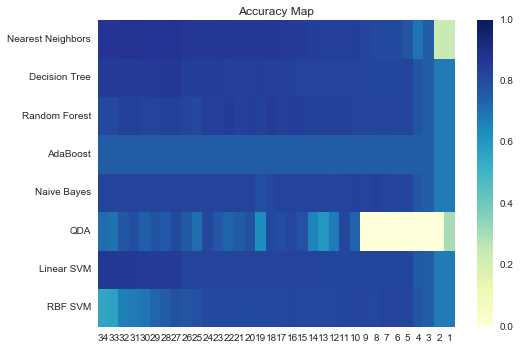

In [51]:
from seaborn import heatmap

heatmap(accuracies, vmin=0, vmax = 1, yticklabels = names, xticklabels=num_feats, cmap="YlGnBu")
plt.title('Accuracy Map')

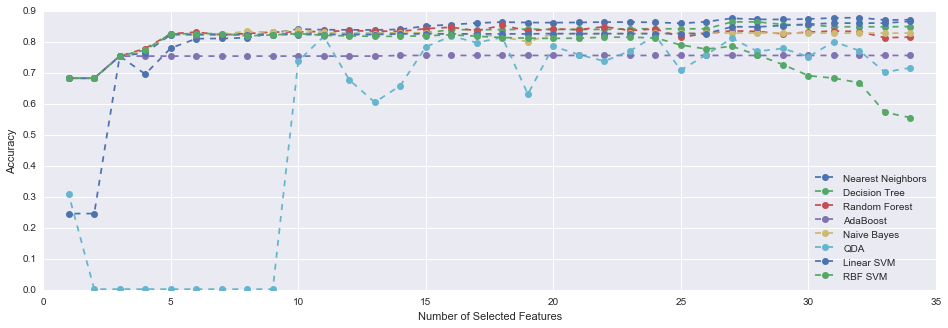

In [52]:
plt.figure(figsize=[16, 5])
for i in range(len(accuracies)):
    plt.plot(num_feats, accuracies[i], 'o--', label = names[i])
plt.legend(loc = 'best')
plt.ylabel('Accuracy')
plt.xlabel('Number of Selected Features')
# plt.xlim([1, 20])
# heatmap(accuracies, vmin=0, vmax = 1, yticklabels = names, xticklabels=num_feats, cmap="YlGnBu")
# plt.title('Accuracy Map')

(0.6, 0.9)

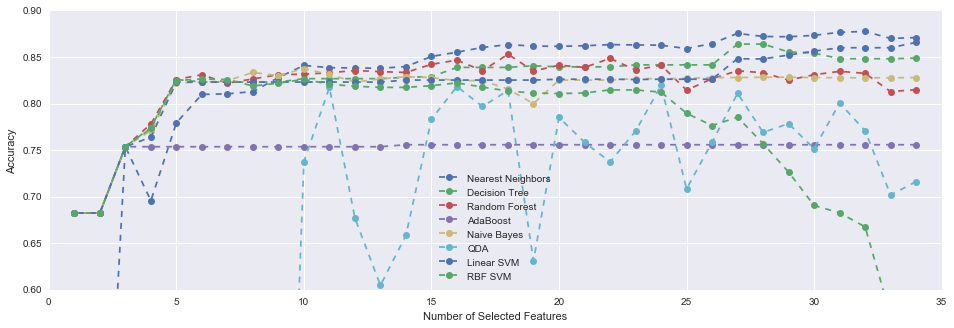

In [53]:
plt.figure(figsize=[16, 5])
for i in range(len(accuracies)):
    plt.plot(num_feats, accuracies[i], 'o--', label = names[i])
plt.legend(loc = 'best')
plt.ylabel('Accuracy')
plt.xlabel('Number of Selected Features')
plt.ylim([0.6, 0.9])
# heatmap(accuracies, vmin=0, vmax = 1, yticklabels = names, xticklabels=num_feats, cmap="YlGnBu")
# plt.title('Accuracy Map')

In [54]:
np.max(accuracies), np.where(accuracies == np.max(accuracies))

(0.87783489567583917, (array([0]), array([2])))

Decision Tree
Optimal number of features : 5


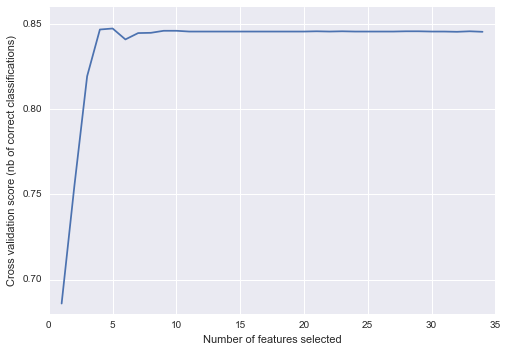

Random Forest
Optimal number of features : 8


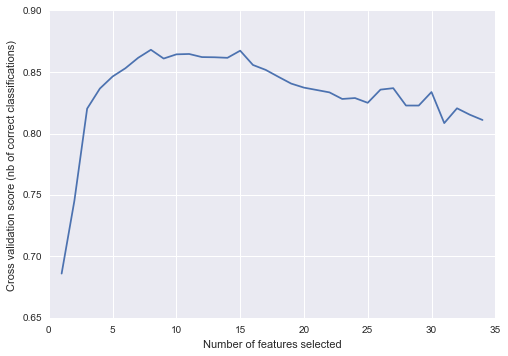

AdaBoost
Optimal number of features : 34


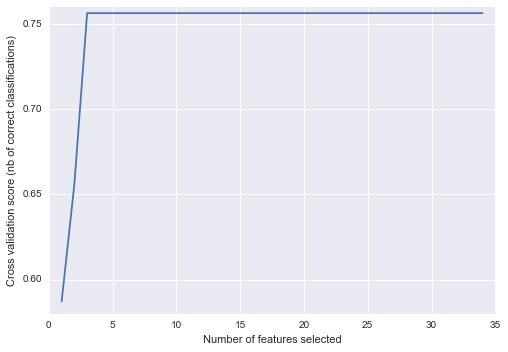

Linear SVM
Optimal number of features : 22


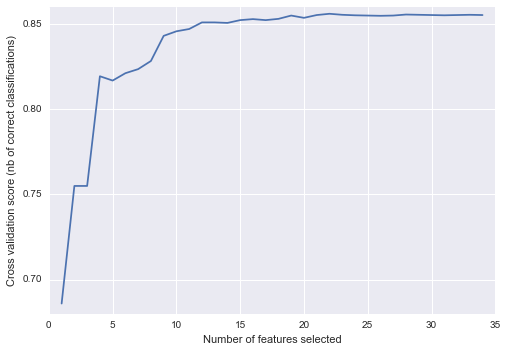

In [55]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

names = ["Decision Tree", "Random Forest", "AdaBoost", "Linear SVM"]

classifiers = [
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=10, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    SVC(kernel="linear", C=0.025)]

for i in np.arange(len(classifiers)):
    clf = classifiers[i]
    rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(3),
                  scoring='accuracy')
    rfecv.fit(train_set, train_label)
    print(names[i])
    print("Optimal number of features : %d" % rfecv.n_features_)

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()